In [3]:
import os
import whisper
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

As the task asked to predict an output given an Input and given the Output is continuous , the best way to solve this is using these techniques Linear regression, decision trees, random forest regression, Support vector regression, and neural networks

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model("base").to(device)

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 82.6MiB/s]


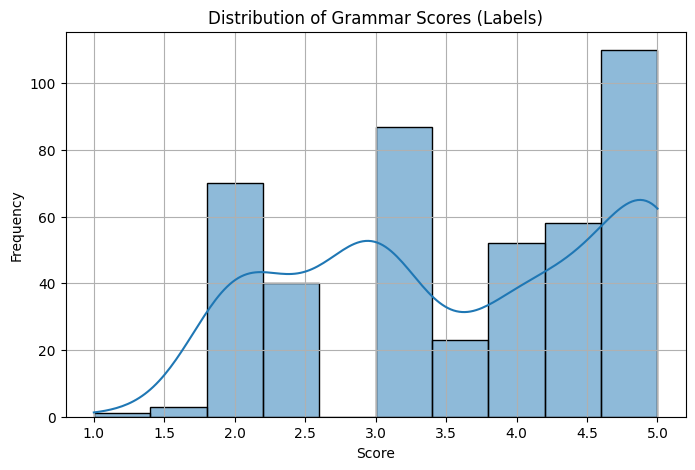

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(train_df['label'], bins=10, kde=True)
plt.title('Distribution of Grammar Scores (Labels)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
def extract_whisper_embedding(audio_path):
    audio = whisper.load_audio(audio_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(device)

    with torch.no_grad():
        encoded = model.encoder(mel.unsqueeze(0))

    return encoded.squeeze(0).mean(dim=0).cpu().numpy()

In [7]:
train_df = pd.read_csv("/content/drive/MyDrive/dataset/train.csv")
train_df['file_path'] = train_df['filename'].apply(lambda x: os.path.join("/content/drive/MyDrive/dataset/audios_train", x))

X = []
y = []

for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        emb = extract_whisper_embedding(row["file_path"])
        X.append(emb)
        y.append(row["label"])
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")

100%|██████████| 444/444 [06:35<00:00,  1.12it/s]


In [8]:
X = np.vstack(X)
y = np.array(y)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
reg = MLPRegressor(hidden_layer_sizes=(512,256,128,64), activation='relu',
                   solver='adam', max_iter=10000, random_state=42)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

In [12]:
test_df = pd.read_csv("/content/drive/MyDrive/dataset/test.csv")
test_df['file_path'] = test_df['filename'].apply(lambda x: os.path.join("/content/drive/MyDrive/dataset/audios_test", x))

test_features = []

for file in tqdm(test_df["file_path"]):
    try:
        emb = extract_whisper_embedding(file)
        test_features.append(emb)
    except:
        test_features.append(np.zeros_like(X[0]))

test_features = np.vstack(test_features)
test_preds = reg.predict(test_features)

100%|██████████| 195/195 [02:50<00:00,  1.14it/s]


In [137]:
from sklearn.neural_network import MLPRegressor
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.21, random_state=42)
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1000.0, epsilon=0.00001))
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (SVR): {rmse:.4f}")

Validation RMSE (SVR): 0.5363


In [149]:
from sklearn.neural_network import MLPRegressor
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.21, random_state=42)
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(512,464,256), activation='tanh', solver='sgd', max_iter=500000, random_state=42)
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (MLP Neural Net): {rmse:.4f}")

Validation RMSE (MLP Neural Net): 0.5332


In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (Linear Regression): {rmse:.4f}")

Validation RMSE (Linear Regression): 1.3604


In [155]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=10, random_state=42)
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (Decision Tree): {rmse:.4f}")

Validation RMSE (Decision Tree): 1.5099


In [157]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=150, max_depth=12, random_state=42)
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (Random Forest): {rmse:.4f}")

Validation RMSE (Random Forest): 0.7776


In [159]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.1))
model.fit(X_train, y_train)

val_preds = model.predict(X_val)
rmse = mean_squared_error(y_val, val_preds)
print(f"Validation RMSE (SVR): {rmse:.4f}")

Validation RMSE (SVR): 0.5763


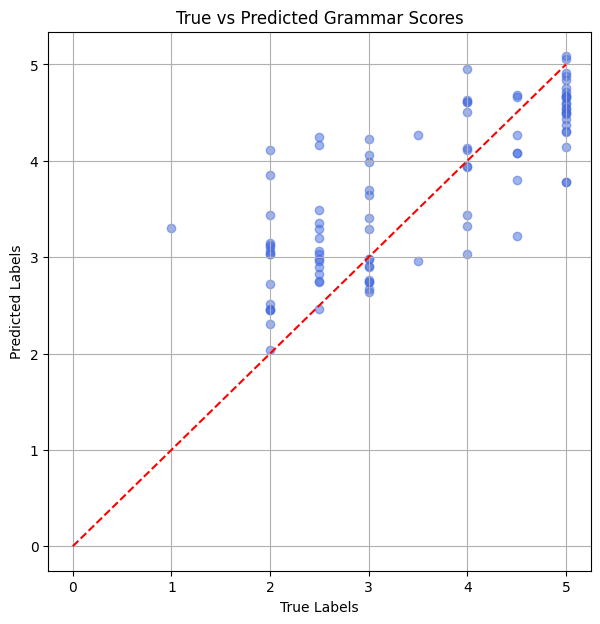

In [163]:
import numpy as np

plt.figure(figsize=(7, 7))
plt.scatter(y_val, val_preds, alpha=0.5, color='royalblue')
plt.plot([0, 5], [0, 5], '--', color='red')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Grammar Scores')
plt.grid(True)
plt.show()

For all the different models the below function remains same to save the file

In [151]:
import pandas as pd
import os
test_features = np.vstack(test_features)
test_preds = model.predict(test_features)
sample_submission_path = "/content/drive/MyDrive/dataset/sample_submission.csv"
submission = pd.read_csv(sample_submission_path)
submission['label'] = test_preds
submission.to_csv("submission.csv", index=False)
print( os.path.abspath("submission.csv"))


/content/submission.csv
